# CITS5553 Data Capstone Project
## Classifying Mineral Grains Using Data Science
### Peter Millitz (Student No. 23088298)
### Date: 22 Oct 2023    


# Mineral Grains dataset pre-processing pipeline

This jupyter notebook is specifically intended for pre-processing input subsets of the Data Capstone G8 Mineral Grains dataset prior to constructing and training the model. A separate notebook is provided for the latter.

## 1. Setup and configuration

### 1.1 Load common libraries and settings

In [2]:
import pandas as pd
import numpy as np
import time
import os

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.display import Markdown

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(IMAGES_PATH, exist_ok=True)

### 1.2 Data repository access

In [3]:
os.access("G:/Modelling", os.F_OK)

True

## 2. Load, examine and clean the dataset

### 2.1 Examine the dataset

In [5]:
input_csvfile  = "G:/Modelling/FINAL_PROCESSED/10_combined_shuffled.csv"
output_csvfile = "G:/Modelling/FINAL_PROCESSED/10_combined_shuffled_proc.csv"

In [6]:
# Load data file
rawdata = pd.read_csv(input_csvfile)

In [7]:
# Examine the first few lines
rawdata.head()

,x,y,yinv,CH_1,CH_2,CH_3,CH_4,CH_5,CH_6,CH_7,...,CH_4089,CH_4090,CH_4091,CH_4092,CH_4093,CH_4094,CH_4095,CH_4096,Sum,Mineral Phase
0,8800,6400,11400,0,0,0,0,0,0,0,...,0,0,1,0,2,0,0,0.0,8439,AlFe-Silicate
1,8000,11600,5800,0,0,0,0,0,0,0,...,0,0,1,0,2,2,1,1.0,2971,Background
2,3200,7800,9400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2.0,10613,Fe-Oxide
3,0,6200,10400,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2.0,3970,Background
4,15800,12800,4600,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,2.0,11347,Fe-Oxide


In [8]:
# Get some info on the data set
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44045 entries, 0 to 44044
Columns: 4101 entries, x to Mineral Phase
dtypes: float64(1), int64(4099), object(1)
memory usage: 1.3+ GB


### 2.2 Fix missing values

In [9]:
# Get the total number of missing values
rawdata.isna().sum()

x                   0
y                   0
yinv                0
CH_1                0
CH_2                0
                 ... 
CH_4094             0
CH_4095             0
CH_4096          4281
Sum                 0
Mineral Phase       0
Length: 4101, dtype: int64

In [10]:
# Confirm missing values and get index of column(s)
np.where(pd.isnull(rawdata))
print(set((np.where(pd.isnull(rawdata)))[1])) # prints index of column(s) with null values

{4098}


In [11]:
# Replace the missing values with zeros (if applicable - channel counts only)
rawdata.fillna(0, inplace=True)

### 2.3 Drop unused rows and columns

In [13]:
# Create a list of the columns to drop (retain channels 121-2500 and 'Mineral Phase' column)
columns_to_drop = list(rawdata.columns[:123]) + list(rawdata.columns[2503:-1])
# Drop designated columns
rawdata.drop(columns=columns_to_drop, inplace=True, axis=1)

In [14]:
# Get row indices of rows with minerals not in the followin list
minerals_list = ['Amphibole', 'Background', 'Epidote', 'Fe-Oxide', 'Fe-Silicate',
                 'Ilmenite', 'Monazite', 'Rutile', 'Titanite', 'Zircon']
rows_to_delete = rawdata[~rawdata['Mineral Phase'].isin(minerals_list)].index
# drop these row from the dataframe
rawdata.drop(rows_to_delete, inplace = True)

In [15]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33180 entries, 1 to 44042
Columns: 2381 entries, CH_121 to Mineral Phase
dtypes: int64(2380), object(1)
memory usage: 603.0+ MB


### 2.4 Export the conditioned dataset

In [16]:
rawdata.head(10)
#rawdata.loc[rawdata['Mineral Phase'] == 'Mineral Phase']

,CH_121,CH_122,CH_123,CH_124,CH_125,CH_126,CH_127,CH_128,CH_129,CH_130,...,CH_2492,CH_2493,CH_2494,CH_2495,CH_2496,CH_2497,CH_2498,CH_2499,CH_2500,Mineral Phase
1,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,Background
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fe-Oxide
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,Background
4,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Fe-Oxide
5,0,0,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,Background
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Ilmenite
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Background
9,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,Background
10,0,1,0,0,0,0,0,2,1,0,...,0,1,0,1,0,0,0,0,0,Epidote
11,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,Epidote


In [18]:
# Save the conditioned dataset as a CSV file
rawdata.to_csv(output_csvfile, index=False)

## 3. Data re-sampling (optional)

### 3.1 Response categories

In [17]:
# Check response category proportions
mineral_groups = rawdata.groupby('Mineral Phase').size()
mineral_groups

Mineral Phase
Amphibole      3984
Background     7000
Epidote        5193
Fe-Oxide       7000
Fe-Silicate    1229
Ilmenite       5808
Monazite        408
Rutile          611
Titanite       1768
Zircon          179
dtype: int64

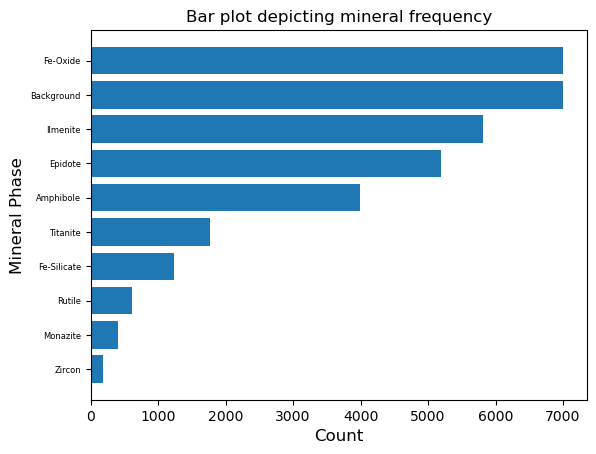

In [19]:
# Plot a barplot of the mineral frequencies

# Sort the grouped data by count in ascending order (bottom up)
mineral_groups = mineral_groups.sort_values(ascending=True)

# Create a horizontal bar plot
plt.barh(mineral_groups.index, mineral_groups.values)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Mineral Phase')
plt.title('Bar plot depicting mineral frequency')
plt.tick_params(axis='y', labelsize=6)

# Show the plot
plt.show()

### 3.2 Prepare the training set

In [ ]:
 # Make a copy of the dataframe, call it X
X = rawdata
# breakout the 'Mineral Phase'attribute and store in y (target)
y = X['Mineral Phase'].copy()
# Drop response attribute from X
X.drop(columns=['Mineral Phase'], inplace=True)

In [ ]:
# Check the shape of all input arrays
print ('The shape of X is:', X.shape)
print ('The shape of y is: ', y.shape)
print ('Number of training examples:', len(X))

### 3.3 Balance the data set using random under-sampling

In [ ]:
# Balance the data set (modify dictionary as required)
mindict = {"AlFe-Silicate": 13000,
           "AlMn-Silicate": 13000,
           "Amphibole":     13000,
           "Background":    13000,
           "Epidote":       13000,
           "Fe-Oxide":      13000,
           "Fe-Silicate":   13000,
           "Ilmenite":      13000,
           "Monazite":      13000,
           "Rutile":        13000,
           "Titanite":      13000,
           "Zircon":        13000}
rus = RandomUnderSampler(random_state=42, sampling_strategy=mindict)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

In [ ]:
X_resampled

#### Appendix: Load and display the mineral list derived from the full dataset for reference

In [20]:
# Load large Sample minerals reference list
classes = pd.read_csv("G:/Modelling/labels_all.csv")

In [21]:
# Convert from pandas dataframe to series
classes.value_counts() # list of class frequencies

Mineral Phase   
Fe-Oxide            20883184
Background          11347230
Ilmenite             8400629
Epidote              5195663
Amphibole            4404669
AlFe-Silicate        4106622
Fe-Silicate          1784892
Titanite             1512827
AlMn-Silicate        1326232
Rutile                876502
Zircon                618053
Monazite              408111
Quartz                404580
Cassiterite           371466
AlK-Silicate          325675
Barite                281363
Al-Silicate           272677
Chromite              266954
Unknown               245718
Leucoxene             150346
Fe-Sulphide           146294
AlCa-Silicate         125414
Apatite                92279
RM ONLY                72136
Xenotime               66880
Carbonate              62444
Thorite                48635
AlFe-Silicate_Zn       34112
Al-Oxide               33373
Fe-Sulphide_Cu         30730
W-Oxide                28626
Zn-Oxide               27213
Fe-sulphide_Pb         26963
Celestine              265

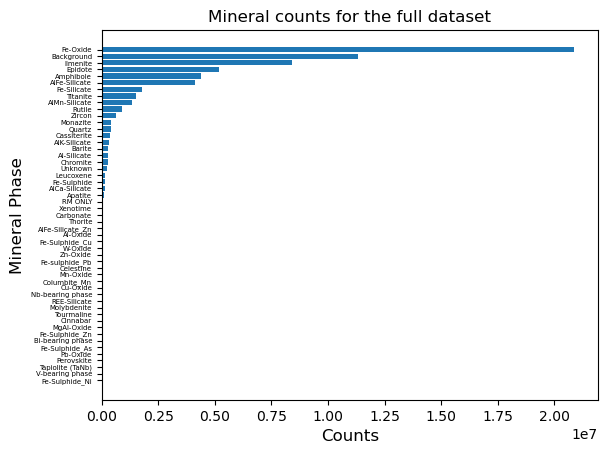

<Figure size 640x480 with 0 Axes>

In [22]:
# Horizontal bar plot illustrating class imbalance

# Group and sort the grouped data by counts (ascending)
minerals = classes.groupby('Mineral Phase').size()
minerals = minerals.sort_values(ascending=True)

# Create a horizontal bar plot
plt.barh(minerals.index, minerals.values)

# Adding labels and title
plt.xlabel('Counts')
plt.ylabel('Mineral Phase')
plt.title('Mineral counts for the full dataset')
plt.tick_params(axis='y', labelsize=5)

# Show the plot
plt.show()
plt.savefig("Mineral_counts.png")